# IMU noise characterization

Three different approaches;
- historgram
- custom Allan deviation
- using allan tools

Familiarity with the IEEE Standard 952 as well as with the nomenclature commonly used, the various units, etc, is helpful.

References

- mixture of gaussian:
https://stackoverflow.com/questions/35990467/fit-mixture-of-two-gaussian-normal-distributions-to-a-histogram-from-one-set-of


In [51]:
%matplotlib inline
# plot the gyroscope historgram for few seconds of data
# https://stackoverflow.com/questions/29208440/fit-a-distribution-to-a-histogram
# https://stackoverflow.com/questions/70164620/how-to-gaussian-fit-histogram
# For gyro input in rad/s, the FWHM will be in rad/s
# TODO find relation between sigma and FWHM
import os # for file manipulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats

HOME = os.getenv("HOME")
#CSV_FILENAME = 'imu_oakdpro_1hr_28032024.csv'
CSV_FILENAME = 'imu_oak_BNO086_6mn_gyroSR400_accSR500.csv'
# CSV_FILENAME = 'imu_oak_BNO086_6mn_gyroSR100_accSR125.csv' 
# CSV_FILENAME = HOME+'/Data/Drones/IMU/imu_oak_BNO086_2hr_02042024.csv'
FS = 100  # Sample rate [Hz]
NOISE_PARAM_UNIT = 'rad'
PRECI= 2
TYPE = "e" # e: exponential notation
TS = 1.0 / FS
NB_SAMPLE = 1000 # nb of samples to take from the input data (csv file) for the historgram
DEG_2_RAD = np.pi / 180.0
RAD_2_DEG = 180.0 / np.pi
NBINS = 30 # number of bins for the histogram

The angular rate sensor is described by the quantities $N$ (angle random walk), $B$ (bias instability) and $K$ (rate random walk) from the IEEE Std 952. The values prescribed here approximate the properties of a Bosch SMI130 yaw rate sensor.

In [2]:
N = 5e-3 # °/sqrt(s) = 0.3 °/sqrt(h)
B = 7e-4 # °/s = 2.5 °/h
K = 6e-6 # °/s/sqrt(s)

Define the sampling rate ``fs`` and initialize noise sources:

In [52]:
# functions
# for FHWM
def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

In [53]:
# Load CSV into np array (take few seconds so put in a separate cell)
dataArr = np.genfromtxt(CSV_FILENAME, delimiter=',')

In [54]:
# Separate into arrays and select a slice of the input data
acc_ts = dataArr[:NB_SAMPLE, 0]  # time stamp for acceleration, second
accx = dataArr[:NB_SAMPLE, 1]  # m/s²
accy = dataArr[:NB_SAMPLE, 2]
accz = dataArr[:NB_SAMPLE, 3]
ts = dataArr[:NB_SAMPLE, 4]  # time stamp, second
gx = dataArr[:NB_SAMPLE, 5]  # (rad/s)
gy = dataArr[:NB_SAMPLE, 6]
gz = dataArr[:NB_SAMPLE, 7]

In [5]:
# Rerun and compare with data at the end of the data gathering (2hrs after start)
acc_ts = dataArr[-NB_SAMPLE:, 0]  # time stamp for acceleration, second
accx = dataArr[-NB_SAMPLE:, 1]  # m/s²
accy = dataArr[-NB_SAMPLE:, 2]
accz = dataArr[-NB_SAMPLE:, 3]
ts = dataArr[-NB_SAMPLE:, 4]  # time stamp, second
gx = dataArr[-NB_SAMPLE:, 5]  # (rad/s)
gy = dataArr[-NB_SAMPLE:, 6]
gz = dataArr[-NB_SAMPLE:, 7]

In [55]:
# get some parameters about the data collection
dataArr_shape = dataArr.shape
tot_nb_sample = dataArr_shape[0]
print(f'total number of samples: {tot_nb_sample}')

total number of samples: 144000


1000
[  1.  15.  62. 179. 100.  74.   1.   0.   0.   0.   0.   0.   0.  12.
  78. 310. 122.  43.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   1.] [1.565  1.6542 1.7434 1.8326 1.9218 2.011  2.1002 2.1894 2.2786 2.3678
 2.457  2.5462 2.6354 2.7246 2.8138 2.903  2.9922 3.0814 3.1706 3.2598
 3.349  3.4382 3.5274 3.6166 3.7058 3.795  3.8842 3.9734 4.0626 4.1518
 4.241 ] <BarContainer object of 30 artists>
[ 4.01136057e-01  1.06164323e+00 -9.50079102e-01  5.55623591e+02
  3.69616573e+03  2.51616010e+00] 
 [1.14597556e+00 1.22721868e+00 5.07405356e-01 3.46927591e+02
 4.59410694e+03 2.50209198e-02]
Gaussian best fit mu, sigma = ((2.5061980000000004, 2.5061224999999996), (0.5317296646755748, 0.06265504962690695))
[0.15662671 0.20783228 0.2681257  0.33631186 0.41013251 0.48627786
 0.56056125 0.62826077 0.68459715 0.7252847  0.74706816 0.74815265
 0.7284479  0.68958063 0.63467282 0.56792766 0.49409952 0.41794017
 0.34370994 0.27482    0.21364015 0.16147143 0.11865521 0.08477273
 0.05

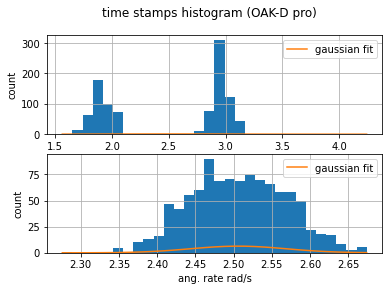

In [71]:
acc_ts_grad=np.gradient(acc_ts)
gyro_ts_grad=np.gradient(ts)
print(len(acc_ts_grad))
# print(f'{np.gradient(acc_ts)}')
# plt.hist(acc_ts_grad,NBINS)
f, axarr = plt.subplots(2, sharex=False)
# f.set_figheight(12)
# f.set_figwidth(8)
f.suptitle(f'time stamps histogram (OAK-D pro)',fontsize = 12)
a, bins_acc_ts, b = axarr[0].hist(acc_ts_grad, NBINS) #, density=1, alpha=0.5,label='accel time stamp')
_, bins_gyro_ts, _ = axarr[1].hist(gyro_ts_grad, NBINS) #, density=1, alpha=0.5,label='gyro time stamp')
print(a,bins_acc_ts,b)



# axarr[0].set_title('Gyro Angular rate X')
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)
def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected=(1.8,.5,2,3,.5,2)
params,cov=curve_fit(bimodal,np.arange(len(acc_ts_grad)),acc_ts_grad,expected)
sigma=np.sqrt(np.diag(cov))
print(params,'\n',sigma)  
# params,cov=curve_fit(bimodal,bins_acc_ts,expected)
# print(f'bins from histo: { bins_gx,bins_gy,bins_gz}')
mu, sigma = zip(stats.norm.fit(acc_ts_grad),stats.norm.fit(gyro_ts_grad))

print(f'Gaussian best fit mu, sigma = {mu,sigma}')
gauss_fit_accts = stats.norm.pdf(bins_acc_ts, mu[0], sigma[0])
gauss_fit_gyrots = stats.norm.pdf(bins_gyro_ts, mu[1], sigma[1])
axarr[0].plot(bins_acc_ts,gauss_fit_accts,label = 'gaussian fit')
axarr[1].plot(bins_gyro_ts,gauss_fit_gyrots,label = 'gaussian fit')
print(gauss_fit_accts)
for i in range(2):
    axarr[i].grid()
    axarr[i].set_ylabel('count')
    axarr[i].set_xlabel('ang. rate rad/s')
    axarr[i].legend()
# print(dataArr.shape)

(array([ 1.,  0.,  0.,  0.,  1.,  5.,  1., 10., 13., 16., 47., 42., 55.,
       60., 90., 69., 71., 69., 74., 70., 66., 58., 58., 50., 22., 18.,
       17.,  8.,  3.,  6.]), array([2.276     , 2.28926667, 2.30253333, 2.3158    , 2.32906667,
       2.34233333, 2.3556    , 2.36886667, 2.38213333, 2.3954    ,
       2.40866667, 2.42193333, 2.4352    , 2.44846667, 2.46173333,
       2.475     , 2.48826667, 2.50153333, 2.5148    , 2.52806667,
       2.54133333, 2.5546    , 2.56786667, 2.58113333, 2.5944    ,
       2.60766667, 2.62093333, 2.6342    , 2.64746667, 2.66073333,
       2.674     ]), <BarContainer object of 30 artists>)


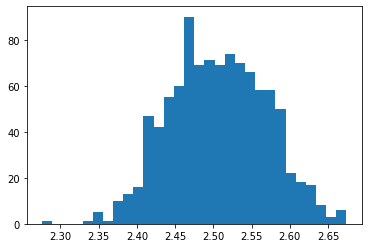

In [61]:
gyro_ts_grad=np.gradient(ts)
# print(f'{np.gradient(acc_ts)}')
a=plt.hist(gyro_ts_grad,NBINS)
print(a)
# print(dataArr.shape)

In [16]:
print(f'average sampling period accelerometer: {np.average(acc_ts_grad):.3}ms')
print(f'average sampling period gyroscope: {np.average(gyro_ts_grad):.3}ms')

average sampling period accelerometer: 2.5ms
average sampling period gyroscope: 2.51ms


In [17]:
# print(f'{acc_ts,ts}')

Now create an artifical sensor noise signal $w_{noise}$ from the individual noise sources denoted by $\xi$. The noise is additive and the coefficients $N$, $B$ and $K$ from the IEEE Std 952 enter as follows:

$$w_{noise} = N\xi_{white} + \frac{B}{\sqrt{2\pi}}\xi_{pink} + \frac{K}{2\pi}\xi_{red}$$

[-0.02024   -0.0189972 -0.0177544 -0.0165116 -0.0152688 -0.014026
 -0.0127832 -0.0115404 -0.0102976 -0.0090548 -0.007812  -0.0065692
 -0.0053264 -0.0040836 -0.0028408 -0.001598  -0.0003552  0.0008876
  0.0021304  0.0033732  0.004616   0.0058588  0.0071016  0.0083444
  0.0095872  0.01083    0.0120728  0.0133156  0.0145584  0.0158012
  0.017044 ]
Gaussian best fit mu, sigma = ((0.000724397, -0.001006672, 0.0016745999999999998), (0.005475682060473472, 0.004972432919247478, 0.006310730232072989))
[4.78000122e-02 1.11079219e-01 2.45168879e-01 5.13955574e-01
 1.02332488e+00 1.93521491e+00 3.47594250e+00 5.92984963e+00
 9.60821011e+00 1.47866236e+01 2.16134083e+01 3.00058001e+01
 3.95653380e+01 4.95509818e+01 5.89409812e+01 6.65901777e+01
 7.14546836e+01 7.28247398e+01 7.04944452e+01 6.48124692e+01
 5.65965491e+01 4.69406448e+01 3.69773568e+01 2.76662561e+01
 1.96604129e+01 1.32697454e+01 8.50668326e+00 5.17947389e+00
 2.99528912e+00 1.64520327e+00 8.58278221e-01]


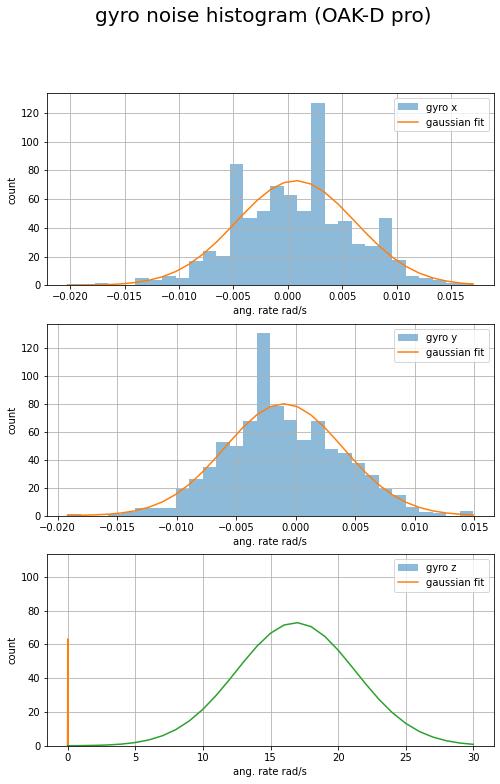

In [70]:
f, axarr = plt.subplots(3, sharex=False)
f.set_figheight(12)
f.set_figwidth(8)
f.suptitle(f'gyro noise histogram (OAK-D pro)',fontsize = 20)
#axarr[0].plot(t, accX_ref, 'y.',label="ground truth AccX")
_, bins_gx, _ = axarr[0].hist(gx, NBINS, density=1, alpha=0.5,label='gyro x')
_, bins_gy, _ = axarr[1].hist(gy, NBINS, density=1, alpha=0.5,label='gyro y')
_, bins_gz, _ = axarr[2].hist(gz, NBINS, density=1, alpha=0.5,label='gyro z')
print(bins_gx)
for i in range(3):
    axarr[i].grid()
    axarr[i].set_ylabel('count')
    axarr[i].set_xlabel('ang. rate rad/s')

# axarr[0].set_title('Gyro Angular rate X')

# print(f'bins from histo: { bins_gx,bins_gy,bins_gz}')
mu, sigma = zip(stats.norm.fit(gx),stats.norm.fit(gy),stats.norm.fit(gz))

print(f'Gaussian best fit mu, sigma = {mu,sigma}')
gauss_fit_gx = stats.norm.pdf(bins_gx, mu[0], sigma[0])
gauss_fit_gy = stats.norm.pdf(bins_gy, mu[1], sigma[1])
gauss_fit_gz = stats.norm.pdf(bins_gz, mu[2], sigma[2])
axarr[0].plot(bins_gx,gauss_fit_gx,label = 'gaussian fit')
axarr[1].plot(bins_gy,gauss_fit_gy,label = 'gaussian fit')
axarr[2].plot(bins_gz,gauss_fit_gz,label = 'gaussian fit')

hmx = half_max_x(bins_gx,gauss_fit_gx)

axarr[0].legend()
axarr[1].legend()
axarr[2].legend()
plt.plot(gauss_fit_gx)
print(gauss_fit_gx)
#axarr[0].set_ylim([-2, 2])

## same for the acceleration

Gaussian best fit mu, sigma = ((-9.008164533999999, -0.326607378, -0.34318482899999997), (0.035057982837106226, 0.022215669852946495, 0.033899426922940144))
Magnitude of gravity vector: 9.021


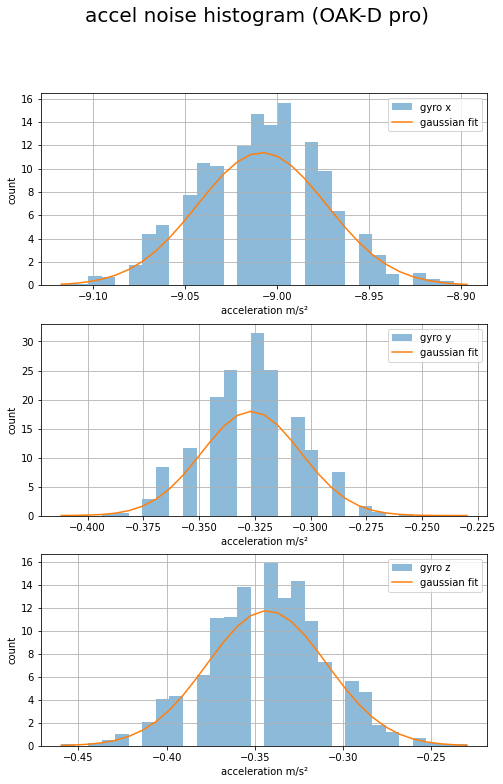

In [22]:
f, axarr = plt.subplots(3, sharex=False)
f.set_figheight(12)
f.set_figwidth(8)
f.suptitle(f'accel noise histogram (OAK-D pro)',fontsize = 20)
#axarr[0].plot(t, accX_ref, 'y.',label="ground truth AccX")
_, bins_accx, _ = axarr[0].hist(accx, NBINS, density=1, alpha=0.5,label='gyro x')
_, bins_accy, _ = axarr[1].hist(accy, NBINS, density=1, alpha=0.5,label='gyro y')
_, bins_accz, _ = axarr[2].hist(accz, NBINS, density=1, alpha=0.5,label='gyro z')
for i in range(3):
    axarr[i].grid()
    axarr[i].set_ylabel('count')
    axarr[i].set_xlabel('acceleration m/s²')
    
# print(f'bins from histo: { bins_gx,bins_gy,bins_gz}')
mu, sigma = zip(stats.norm.fit(accx),stats.norm.fit(accy),stats.norm.fit(accz))

print(f'Gaussian best fit mu, sigma = {mu,sigma}')
g_eval = np.linalg.norm(mu)
print(f'Magnitude of gravity vector: {g_eval:.4}')
gauss_fit_accx = stats.norm.pdf(bins_accx, mu[0], sigma[0])
gauss_fit_accy = stats.norm.pdf(bins_accy, mu[1], sigma[1])
gauss_fit_accz = stats.norm.pdf(bins_accz, mu[2], sigma[2])
axarr[0].plot(bins_accx,gauss_fit_accx,label = 'gaussian fit')
axarr[1].plot(bins_accy,gauss_fit_accy,label = 'gaussian fit')
axarr[2].plot(bins_accz,gauss_fit_accz,label = 'gaussian fit')

# hmx = half_max_x(bins_accx,gauss_fit_accx)

axarr[0].legend()
axarr[1].legend()
axarr[2].legend()
#axarr[0].set_ylim([-2, 2])

In [5]:
# histogram analysis : accelerometer
_, bins_accx, _ = plt.hist(accx, 20, density=1, alpha=0.5)
_, bins_accy, _ = plt.hist(accy, 20, density=1, alpha=0.5)
_, bins_accz, _ = plt.hist(accz, 20, density=1, alpha=0.5)

_, bins_gx, _ = plt.hist(gx, 20, density=1, alpha=0.5)
_, bins_gy, _ = plt.hist(gy, 20, density=1, alpha=0.5)
_, bins_gz, _ = plt.hist(gz, 20, density=1, alpha=0.5)
print(f'bins from histo: { bins_gx,bins_gy,bins_gz}')
mu, sigma = zip(stats.norm.fit(gx),stats.norm.fit(gy),stats.norm.fit(gz))

print(f'Gaussian best fit mu, sigma = {mu,sigma}')
best_fit_line = stats.norm.pdf(bins_gx, mu[0], sigma[0])
# plt.plot(bins_gx, best_fit_line)
#x = gx.index.values
#y = np.array(gx['ABC'])
print(f'best_fit_line = {best_fit_line}')
x = bins_gx
#x = np.arange(len(gx))
#hmx = half_max_x(bins,gx) #x,y)
hmx = half_max_x(bins_gx,best_fit_line) #x,y)
#hmx = half_max_x(ts,gx) #x,y)
fwhm = (hmx[1] - hmx[0]) # 
print(f'FWHM = {fwhm:.{PRECI}}{NOISE_PARAM_UNIT}/s, hmx = {hmx}')

plt.plot([hmx[0],hmx[0]], [0,50])
plt.plot([hmx[1],hmx[1]], [0,50])
f, axarr = plt.subplots(3, sharex=True)
f.set_figheight(12)
f.set_figwidth(8)
f.suptitle(f'gyro noise histogram (OAK-D pro)',fontsize = 20)
#axarr[0].plot(t, accX_ref, 'y.',label="ground truth AccX")
_, bins, _ = axarr[0].hist(gx, 20, density=1, alpha=0.5)
#    axarr[0].plot(t, accX_best, "r-", label="best sensor")
#    axarr[0].plot(t, accX_good, "b-", label="good sensor")
#    axarr[0].plot(t, accX_worst, "g--", label="worst sensor")
axarr[0].set_title('Gyro Angular rate X')
axarr[0].grid()
axarr[0].legend()
#axarr[0].set_ylim([-2, 2])

plt.show()


Now calculate the Allan variance. The module ``allan`` is not provided by ``pyplnoise``, but many similar codes can be found on pypi.

In [6]:
tau, avar, adev, error_adev_pct = allan.allan_variance(w, dt=1./fs, n_clusters=8000,
                                                       verbose=False)

In [7]:
# omit values with insufficient statistical quality
idx_valid = error_adev_pct < 10
avar_valid = avar[idx_valid]
adev_valid = adev[idx_valid]
tau_valid = tau[idx_valid]

Here's how the calculated Allan deviation looks like.

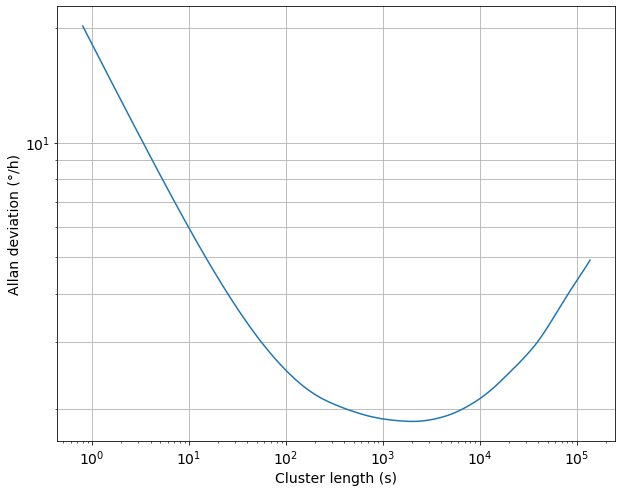

In [15]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax.loglog(tau_valid, adev_valid*3600)
ax.set_xlabel("Cluster length (s)")
ax.set_ylabel("Allan deviation (°/h)")
ax.grid(True, which='major')
ax.grid(True, which='minor', axis='y')

Let's extract the properties $N$, $B$ and $K$ automatically:

In [9]:
noise_density, a_n_fit, b_n_fit = allan.read_noise_density(adev_valid, tau_valid)
print("Extracted angle random walk: N = {:.4g} °/s/sqrt(Hz) = {:.5f} °/sqrt(h)"
      .format(noise_density, noise_density*60))
bias_instability = allan.read_bias_instability(adev_valid, tau_valid)
print("Extracted bias instability: B = {:.4g} °/s = {:.5f} °/h"
      .format(bias_instability, bias_instability*3600))
rate_random_walk, a_k_fit, b_k_fit = allan.read_rate_random_walk(adev_valid, tau_valid)
print("Extracted rate random walk: K = {:.4g} °/s^(3/2) = {:.5f} °/h^(3/2)"
      .format(rate_random_walk, rate_random_walk*3600**(3/2)))

Extracted angle random walk: N = 0.005027 °/s/sqrt(Hz) = 0.30159 °/sqrt(h)
Extracted bias instability: B = 0.0007754 °/s = 2.79154 °/h
Extracted rate random walk: K = 6.792e-06 °/s^(3/2) = 1.46705 °/h^(3/2)


If you rather prefer to find these values manually, you can read off the value of the red line at $\tau = 1$ to get $N$. The value of the green line at $\tau = 3$ is equal to $K$, and multiplication of the global minimum by $\sqrt{\frac{\pi}{2\ln 2}}\approx1/0.664$ yields $B$.

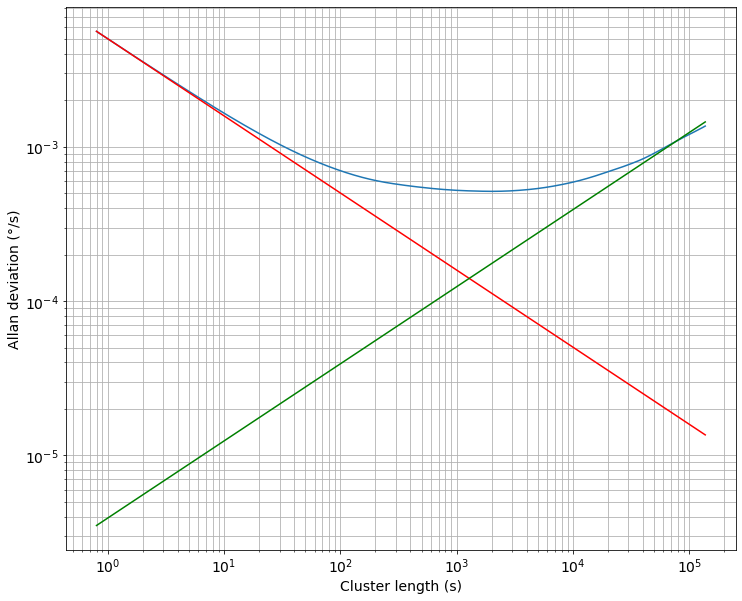

In [16]:
fit_vals_n = np.power(10.0, a_n_fit * np.log10(tau_valid) + b_n_fit)
fit_vals_k = np.power(10.0, a_k_fit * np.log10(tau_valid) + b_k_fit)
fig = plt.figure(figsize=(12,10))
ax = fig.gca()
ax.loglog(tau_valid, adev_valid)
ax.loglog(tau_valid, fit_vals_n, color='red')
ax.loglog(tau_valid, fit_vals_k, color='green')
ax.set_xlabel("Cluster length (s)")
ax.set_ylabel("Allan deviation (°/s)")
ax.grid(True, which='both')